In [ ]:
!pip install tokenizers==0.9.4
!pip install simpletransformers

In [1]:
from transformers import DistilBertTokenizer, AdamW, DistilBertModel, DistilBertConfig
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
import torch.nn as nn

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Read data from csv files

In [3]:
def read_train_and_test(train_path, test_path): #path: path of the whole dataset
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

train_path = "../input/founta-withouout-spam/train_re_1.csv"
test_path = "../input/founta-withouout-spam/validate.csv"
train_csv, test_csv = read_train_and_test(train_path, test_path)

In [4]:
train_csv.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'tweet', 'label', 'number_votes', 'num_label'],
      dtype='object')

In [5]:
train_labels = list(train_csv.num_label.values)
print(train_labels.count(0))
print(train_labels.count(1))
print(train_labels.count(2))
print(train_labels.count(3))

2951
2951
2951
0


In [6]:
print(train_csv.tweet.values[:10])

['Good analysis of whats at stake for farming and the environment from #Brexit by @BarryGardiner on #bbcaq'
 "His scenes with clay are the funniest, also it's funny that he attends school he looks so much older but I sill lov… https://t.co/iDZzNWgnvN"
 "@Whoalaurens i think he's cute or w/e and he makes good music but i can also make fun of him w/o a guilty conscience"
 "@FoxNews @nypost I aplaud this initiative, it's to give more equality to black Americans at the college."
 '@ Davidson professor: when u assign a mandatory movie at a specific time and place, we expect you to show up'
 'RT @lilprinsus: men are so ugly like ill put money on his dick being under 6 inches dont speak on womens tits when u probably 2 sma…'
 '@SetItOff @MaxxSIO @CodySIO if I can make u guys laugh with why Im gonna be on crutches for ur show tonight will u let me come onstage w you'
 'Dell Inspiron 15.6" i3-5015U 4GB 1TB I3558-5500BLK HDMI BT https://t.co/hSZxMEngXm https://t.co/KLjYuhvMT2'
 "RT @AntiRyro: RT

## Run tokenizer

In [7]:
def run_tokenizer(train_csv, test_csv, merge_label=False, add_token=False):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 
    if add_token:
      tokenizer.add_tokens(add_token)

    def get_max_len(tokenizer, train_csv):
        tweets = train_csv.tweet.values
        max_length = 0
        for t in tweets:
          ids = tokenizer.encode(t)
          max_length = max(len(ids),max_length)
        return max_length if max_length <= 512 else 512

    max_length = get_max_len(tokenizer, train_csv)
    train_tweets, train_labels = train_csv.tweet.values, train_csv.num_label.values
    test_tweets, test_labels = test_csv.tweet.values, test_csv.num_label.values
    if merge_label == True:
       train_labels = [l if l ==0 else 1 for l in train_labels]
       test_labels = [l if l ==0 else 1 for l in test_labels]

    def tokenize_for_tweet(tokenizer, tweets, labels):
        input_ids = []
        attention_masks = []

        for t in tweets:
            input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length',return_tensors='pt')
            input_ids.append(input_dict['input_ids'])
            attention_masks.append(input_dict['attention_mask'])
        input_ids = torch.cat(input_ids,dim=0)
        attention_masks = torch.cat(attention_masks,dim=0)
        labels=torch.tensor(labels)
        dataset = TensorDataset(input_ids, attention_masks, labels)
        return dataset
        
    train_dataset = tokenize_for_tweet(tokenizer, train_tweets, train_labels)
    test_dataset = tokenize_for_tweet(tokenizer, test_tweets, test_labels)
    num_label = 3 if merge_label == False else 2
    return train_dataset, test_dataset, num_label, tokenizer

#tokens = ['<SWEAR-0>', '<SWEAR-1>', '<SWEAR-2>', '<SWEAR-3>', '<SWEAR-4>']
train_dataset, test_dataset, num_label, tokenizer = run_tokenizer(train_csv, test_csv, merge_label = False)#,add_token = tokens)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

## Make data loader

In [8]:
batch_size = 20

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

## Define classifier and adversary

In [9]:
configuration = DistilBertConfig()
#configuration.output_hidden_states = True
#print(configuration)

In [10]:
class Classifier(nn.Module):
  def __init__(self, num_label):
    super().__init__()
    self.bert = DistilBertModel.from_pretrained('distilbert-base-cased')
    #self.bert.resize_token_embeddings(len(tokenizer))
    self.linear = nn.Linear(configuration.hidden_size, num_label)

  def forward(self, input_ids, attention_mask): # input_id [batch_size, sentence_length]
    last_hidden_state = self.bert(input_ids, attention_mask)[0] # last_hidden_state [batch_size, sentence_length, hidden_size]
    last_hidden_state_mean = torch.mean(last_hidden_state, dim=1) # last_hidden_state [batch_size, hidden_size]
    output = self.linear(last_hidden_state_mean) # output [batch_size, num_label]
    return last_hidden_state_mean, output


In [ ]:
class Adversary_lstm(nn.Module):
  def __init__(self, num_protected_label, hidden_size):
    super().__init__()
    self.lstm = nn.LSTM(configuration.hidden_size, hidden_size,bidirectional=True, batch_first=True)
    #self.relu = nn.ReLU()
    self.linear = nn.Linear(hidden_size*2, num_protected_label)

  def forward(self, clf_input):
    #clf_input = torch.unsqueeze(clf_input, dim=1)
    lstm, _ = self.lstm(clf_input)
    #lstm = torch.squeeze(lstm, dim=1)
    lstm = lstm[:,-1,:]
    #output1 = self.relu(lstm)
    output = self.linear(lstm)
    return output

In [11]:
class Adversary(nn.Module):
  def __init__(self, num_protected_label, hidden_size):
    super().__init__()
    self.linear1 = nn.Linear(configuration.hidden_size, hidden_size)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_size, num_protected_label)

  def forward(self, clf_last_state):
    output1 = self.relu(self.linear1(clf_last_state))
    output = self.linear2(output1)
    return output

## Import some tools for evaluation after each training epoch

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
import numpy as np
import random

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [14]:
def print_matrix(true_labels, predict_labels, default_classes=['hate','abusive','normal']):
  cm = confusion_matrix(true_labels, predict_labels)
  plot_confusion_matrix(true_labels, predict_labels, classes=default_classes ,title='Confusion matrix')

  #Plot normalized confusion matrix
  plot_confusion_matrix(true_labels, predict_labels, classes=default_classes, normalize=True,title='Normalized confusion matrix')

  plt.show()

  print(classification_report(true_labels, predict_labels, target_names=default_classes))

## Training and evaluation function

In [15]:
def joint_training(clf, adv, epochs, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, alpha, model_name):
    best_acc = 0
    for e in range(epochs):
        print('training {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss, total_clf_loss, total_adv_loss = 0, 0, 0

        clf.train(True)
        adv.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label = label.to(DEVICE)

            protected_label = torch.tensor([1 if l == 1 else 0 for l in label], dtype=torch.long).to(DEVICE) # 0 no-offensive 1 offensive
            
            clf.zero_grad()
            adv.zero_grad()

            last_hidden_state, clf_output = clf(input_ids=input, attention_mask=mask)

            adv_output = adv(last_hidden_state)

            clf_loss = loss_function(clf_output, label)
            adv_loss = loss_function(adv_output, protected_label)

            total_loss = clf_loss + alpha*adv_loss

            train_loss += total_loss.item()
            total_clf_loss += clf_loss.item()
            total_adv_loss += adv_loss.item()

            total_loss.backward(retain_graph=True)
            clf_optimizer.step()

            adv_loss.backward()
            adv_optimizer.step()
            

        avg_train_loss = train_loss / len(train_dataloader)
        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! average train loss: {}".format(e+1,avg_train_loss))
        print('total clf loss: {} total adv loss: {}'.format(total_clf_loss, total_adv_loss))
        print('evaluating...')
        best_acc = evaluate(clf, best_acc, test_dataloader, model_name, str(e+1))
        #print('evaluating adversary...')
        #evaluate_adv(adv, clf, test_dataloader)
        #torch.save(adv,"adv"+str(e+1))
        

In [16]:
def evaluate(clf, best_acc, test_dataloader, model_name, epoch):
    num_total, num_correct = 0, 0
    clf.train(False)
    with torch.no_grad():
      eval_loss = 0
      true_labels, predict_labels = [], []
      for input, mask, label in test_dataloader:
          clf.zero_grad()
          
          input = input.to(DEVICE)
          mask = mask.to(DEVICE)
          label = label.to(DEVICE)

          last_hidden_state, output = clf(input_ids=input, attention_mask=mask)

          loss = loss_function(output, label)

          predict_label = torch.argmax(output, dim=1)

          true_labels += label.tolist()
          predict_labels += predict_label.tolist()

          num_correct += (predict_label == label).sum().item()
          num_total += len(label)

          eval_loss += loss.item()

      avg_eval_loss = eval_loss / len(test_dataloader)

      acc = num_correct/num_total
      if acc > best_acc:
        best_acc = acc
      torch.save(clf, epoch+model_name)
      print_matrix(true_labels, predict_labels)

    print('average eval_loss: {}, accuracy: {}'.format(avg_eval_loss,acc))
    return best_acc


In [18]:
def evaluate_adv(adv, clf, test_dataloader):
    clf.train(False)
    adv.train(False)
    with torch.no_grad():
        true_labels, predict_labels = [], []
        for input, mask, label in test_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label=label.to(DEVICE)

            protected_label = torch.tensor([1 if l == 1 else 0 for l in label], dtype=torch.long).to(DEVICE) # 0 no-offensive 1 offensive
            
            clf.zero_grad()
            adv.zero_grad()

            last_hidden_state, clf_output = clf(input_ids=input, attention_mask=mask)

            adv_output = adv(last_hidden_state)

            predict_label = torch.argmax(adv_output, dim=1)
            true_labels += protected_label.tolist()
            predict_labels += predict_label.tolist()
        print_matrix(true_labels, predict_labels, default_classes=['no offensive','offensive']) 
             

## Define the classifier and adversary

In [17]:
def train_clf(clf, epochs, clf_optimizer, train_dataloader, test_dataloader, model_name):
    best_acc = 0
    for e in range(epochs):
        print('training {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss = 0

        clf.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label=label.to(DEVICE)
            
            clf.zero_grad()

            last_hidden_state, clf_output = clf(input_ids=input, attention_mask=mask)
                       
            clf_loss = loss_function(clf_output, label)
            
            train_loss += clf_loss.item()

            clf_loss.backward()
            clf_optimizer.step()

        avg_train_loss = train_loss / len(train_dataloader)
        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! average train loss: {}".format(e+1,avg_train_loss))
        print('evaluating...')
        best_acc = evaluate(clf, best_acc, test_dataloader, model_name, str(e+1))

training 1 epoch...
238.36321306228638 seconds used......
1 training finished! average train loss: 0.6158169520426012
evaluating...
Confusion matrix, without normalization
[[ 682  198  142]
 [ 717 4565  125]
 [1153  397 9215]]
Normalized confusion matrix
[[0.66731898 0.19373777 0.13894325]
 [0.13260588 0.84427594 0.02311818]
 [0.10710636 0.03687877 0.85601486]]


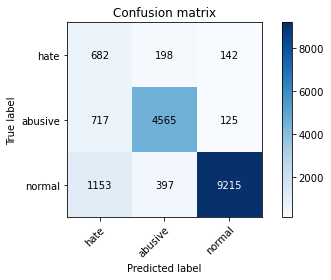

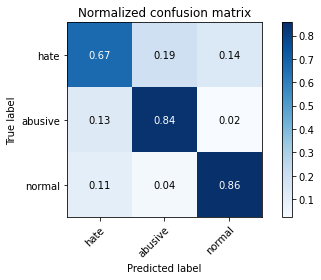

              precision    recall  f1-score   support

        hate       0.27      0.67      0.38      1022
     abusive       0.88      0.84      0.86      5407
      normal       0.97      0.86      0.91     10765

    accuracy                           0.84     17194
   macro avg       0.71      0.79      0.72     17194
weighted avg       0.90      0.84      0.86     17194

average eval_loss: 0.45711241711017697, accuracy: 0.8411073630336163
training 2 epoch...
237.7238552570343 seconds used......
2 training finished! average train loss: 0.4434018538041255
evaluating...
Confusion matrix, without normalization
[[ 711  159  152]
 [ 989 4294  124]
 [1090  340 9335]]
Normalized confusion matrix
[[0.69569472 0.1555773  0.14872798]
 [0.18291104 0.79415572 0.02293323]
 [0.10125406 0.03158384 0.8671621 ]]


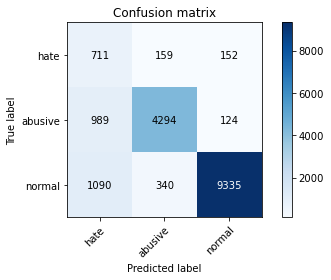

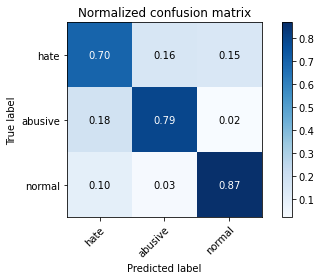

              precision    recall  f1-score   support

        hate       0.25      0.70      0.37      1022
     abusive       0.90      0.79      0.84      5407
      normal       0.97      0.87      0.92     10765

    accuracy                           0.83     17194
   macro avg       0.71      0.79      0.71     17194
weighted avg       0.90      0.83      0.86     17194

average eval_loss: 0.4582809878123361, accuracy: 0.8340118646039316
training 3 epoch...
237.97498178482056 seconds used......
3 training finished! average train loss: 0.3196903430177719
evaluating...
Confusion matrix, without normalization
[[ 683  194  145]
 [ 765 4527  115]
 [1453  435 8877]]
Normalized confusion matrix
[[0.66829746 0.18982387 0.14187867]
 [0.14148326 0.83724801 0.02126873]
 [0.13497445 0.04040873 0.82461681]]


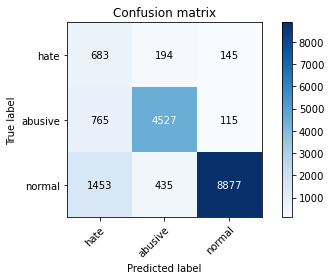

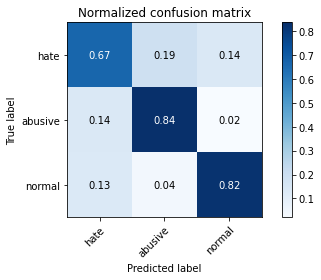

              precision    recall  f1-score   support

        hate       0.24      0.67      0.35      1022
     abusive       0.88      0.84      0.86      5407
      normal       0.97      0.82      0.89     10765

    accuracy                           0.82     17194
   macro avg       0.69      0.78      0.70     17194
weighted avg       0.90      0.82      0.85     17194

average eval_loss: 0.5189642756311006, accuracy: 0.8192974293358148
training 4 epoch...
237.7443721294403 seconds used......
4 training finished! average train loss: 0.21361975785151427
evaluating...
Confusion matrix, without normalization
[[ 734  160  128]
 [1229 4071  107]
 [2143  294 8328]]
Normalized confusion matrix
[[0.71819961 0.15655577 0.12524462]
 [0.22729795 0.75291289 0.01978916]
 [0.19907106 0.02731073 0.77361821]]


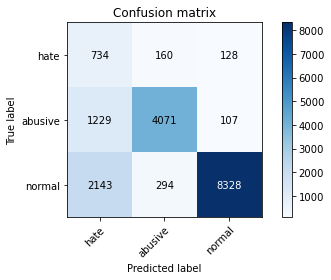

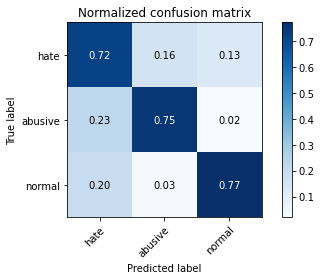

              precision    recall  f1-score   support

        hate       0.18      0.72      0.29      1022
     abusive       0.90      0.75      0.82      5407
      normal       0.97      0.77      0.86     10765

    accuracy                           0.76     17194
   macro avg       0.68      0.75      0.66     17194
weighted avg       0.90      0.76      0.81     17194

average eval_loss: 0.7594749660079563, accuracy: 0.7638129580086076
training 5 epoch...
237.99615240097046 seconds used......
5 training finished! average train loss: 0.14228376321826744
evaluating...
Confusion matrix, without normalization
[[ 746  147  129]
 [1203 4064  140]
 [1572  335 8858]]
Normalized confusion matrix
[[0.72994129 0.14383562 0.12622309]
 [0.22248937 0.75161827 0.02589236]
 [0.1460288  0.03111937 0.82285183]]


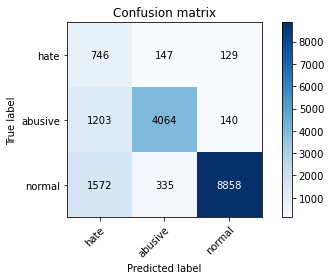

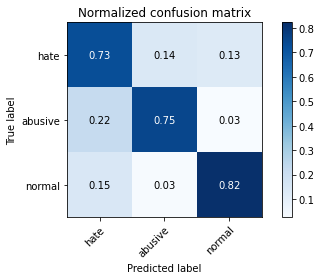

              precision    recall  f1-score   support

        hate       0.21      0.73      0.33      1022
     abusive       0.89      0.75      0.82      5407
      normal       0.97      0.82      0.89     10765

    accuracy                           0.79     17194
   macro avg       0.69      0.77      0.68     17194
weighted avg       0.90      0.79      0.83     17194

average eval_loss: 0.829222418346204, accuracy: 0.7949284634174713


In [18]:
train_clf(classifier, 5, clf_optimizer, train_dataloader, test_dataloader, 'distilbert_clf')

## Joint training
In this step, only the total loss which is defined as L = L<sub>clf</sub> − α∗L<sub>adv</sub> is used for backpropagation. Hence, α is also a import hyperparameter. 

In [21]:
classifier = Classifier(3).to(DEVICE)

adversary = Adversary(2, 200).to(DEVICE)

loss_function = nn.CrossEntropyLoss()

clf_optimizer = AdamW(classifier.parameters(),lr = 2e-5, eps = 1e-8)

adv_optimizer = torch.optim.AdamW(adversary.parameters(), lr=0.001)

0.0
training 1 epoch...
244.09029364585876 seconds used......
1 training finished! average train loss: 0.610749825835228
total clf loss: 270.562172845006 total adv loss: 157.99129321426153
evaluating...
Confusion matrix, without normalization
[[ 656  145  191]
 [ 810 4403  196]
 [ 687  207 9898]]
Normalized confusion matrix
[[0.66129032 0.14616935 0.19254032]
 [0.14975042 0.81401368 0.0362359 ]
 [0.06365827 0.01918087 0.91716086]]


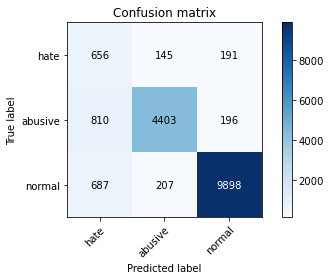

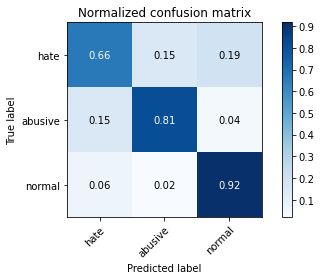

              precision    recall  f1-score   support

        hate       0.30      0.66      0.42       992
     abusive       0.93      0.81      0.87      5409
      normal       0.96      0.92      0.94     10792

    accuracy                           0.87     17193
   macro avg       0.73      0.80      0.74     17193
weighted avg       0.91      0.87      0.89     17193

average eval_loss: 0.3810154759953188, accuracy: 0.8699470714825801
training 2 epoch...
244.2554271221161 seconds used......
2 training finished! average train loss: 0.4459633837468737
total clf loss: 197.56177899986506 total adv loss: 121.91281851008534
evaluating...
Confusion matrix, without normalization
[[ 557  247  188]
 [ 431 4833  145]
 [ 660  347 9785]]
Normalized confusion matrix
[[0.56149194 0.24899194 0.18951613]
 [0.07968201 0.89351082 0.02680717]
 [0.06115641 0.03215345 0.90669014]]


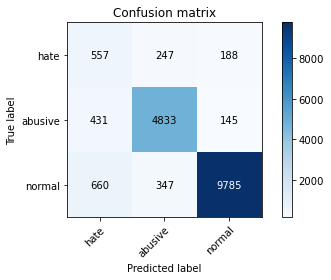

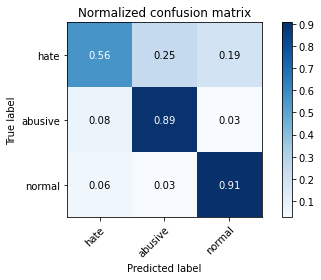

              precision    recall  f1-score   support

        hate       0.34      0.56      0.42       992
     abusive       0.89      0.89      0.89      5409
      normal       0.97      0.91      0.94     10792

    accuracy                           0.88     17193
   macro avg       0.73      0.79      0.75     17193
weighted avg       0.91      0.88      0.89     17193

average eval_loss: 0.37187019268613913, accuracy: 0.882626650380969
training 3 epoch...
244.32784342765808 seconds used......
3 training finished! average train loss: 0.32737144908571353
total clf loss: 145.02555194497108 total adv loss: 98.86814476922154
evaluating...
Confusion matrix, without normalization
[[ 558  280  154]
 [ 435 4832  142]
 [ 974  415 9403]]
Normalized confusion matrix
[[0.5625     0.28225806 0.15524194]
 [0.08042152 0.89332594 0.02625254]
 [0.09025204 0.03845441 0.87129355]]


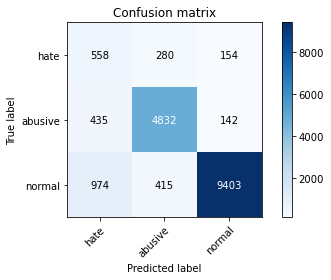

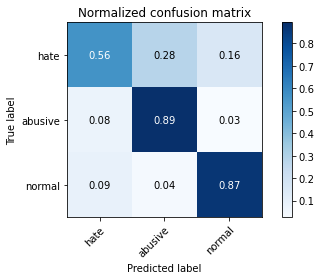

              precision    recall  f1-score   support

        hate       0.28      0.56      0.38       992
     abusive       0.87      0.89      0.88      5409
      normal       0.97      0.87      0.92     10792

    accuracy                           0.86     17193
   macro avg       0.71      0.78      0.73     17193
weighted avg       0.90      0.86      0.88     17193

average eval_loss: 0.4152993141608529, accuracy: 0.8604083057058105
0.1
training 1 epoch...


KeyboardInterrupt: 

In [22]:
alpha = [x * 0.1 for x in range(0, 30)]
for a in alpha:
    print(a)
    joint_training(classifier, adversary, 3, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, a, str(a))
    classifier = Classifier(3).to(DEVICE)
    adversary = Adversary(2, 200).to(DEVICE)

In [ ]:
epochs = 5
alpha = 2
model_name = 'adv_hate_as_noffensive'

joint_training(classifier, adversary, epochs, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, alpha, model_name)

## Rebalance the number of instances in classes
In the prevous experiment, rebalancing is an effective method to increase the true positive rate for hate speech class. (However, the scores of other classes will decrease)

In [ ]:
def rebalance_dataset(dataset):
    data_0 = [inst for inst in dataset if inst[2]==0]
    data_1 = [inst for inst in dataset if inst[2]==1]
    data_2 = [inst for inst in dataset if inst[2]==2]
    random.shuffle(data_0)
    random.shuffle(data_1)
    random.shuffle(data_2)
    num_data0 = len(data_0)
    balanced_dataset = data_0+data_1[:num_data0]+data_2[:num_data0]
    return balanced_dataset

In [ ]:
re_train_dataset = rebalance_dataset(train_dataset)
re_test_dataset = rebalance_dataset(test_dataset)

In [ ]:
batch_size = 20

In [ ]:
re_train_dataloader = DataLoader(re_train_dataset, sampler = RandomSampler(re_train_dataset), batch_size = batch_size)
re_test_dataloader = DataLoader(re_test_dataset, sampler = RandomSampler(re_test_dataset), batch_size = batch_size)

In [ ]:
epochs = 10
alpha = 2
model_name = 'adv_model_hate_as_noffensive'
joint_training(classifier, adversary, epochs, clf_optimizer, adv_optimizer, re_train_dataloader, test_dataloader, alpha, model_name)